# Model development

In [307]:
import pandas as pd

df = pd.read_csv("clean_taxi_data.csv")

In [308]:
df

,Time_of_Day,Day_of_Week,Traffic_Conditions,Trip_Distance_km,Trip_Price
0,Morning,Weekday,Low,19.35,36.2624
1,Evening,Weekend,High,36.87,52.9032
2,Evening,Weekday,Low,30.33,36.4698
3,Afternoon,Weekend,Medium,8.64,60.2028
4,Afternoon,Weekday,High,3.85,11.2645
...,...,...,...,...,...
722,Afternoon,Weekend,Medium,5.49,34.4049
723,Night,Weekday,Medium,45.95,62.1295
724,Morning,Weekday,Low,7.70,33.1236
725,Morning,Weekday,Low,47.56,61.2090


<Axes: xlabel='Trip_Distance_km', ylabel='Trip_Price'>

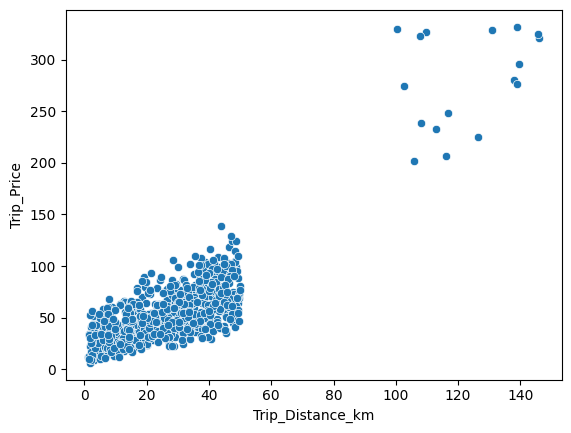

In [309]:
import seaborn as sns

sns.scatterplot(data=df, x="Trip_Distance_km", y="Trip_Price")

## train|test split

1. Delar upp och skapar X och y från dataframe 

In [310]:
y = df["Trip_Price"]
X = df.drop(columns=["Trip_Price"])

In [311]:
y.reset_index()
X

,Time_of_Day,Day_of_Week,Traffic_Conditions,Trip_Distance_km
0,Morning,Weekday,Low,19.35
1,Evening,Weekend,High,36.87
2,Evening,Weekday,Low,30.33
3,Afternoon,Weekend,Medium,8.64
4,Afternoon,Weekday,High,3.85
...,...,...,...,...
722,Afternoon,Weekend,Medium,5.49
723,Night,Weekday,Medium,45.95
724,Morning,Weekday,Low,7.70
725,Morning,Weekday,Low,47.56


Lite sanity checks
- kollar så att kolumnerna stämmer överens
- och så att det inte är några NULLS
- kollar också datatyper

In [312]:
y.shape
X.shape
y.isna().sum()
X.isna().sum()
y.dtype
X.dtypes

Time_of_Day            object
Day_of_Week            object
Traffic_Conditions     object
Trip_Distance_km      float64
dtype: object

Delar upp i tränings- och testsplits

In [313]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)


print(f"{X_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_train.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (487, 4)
X_test.shape = (240, 4)
y_train.shape = (487,)
y_test.shape = (240,)


In [314]:
X_train.head()
y_test.head()

513    78.9521
693    58.6555
377    55.7598
33     44.1197
63     42.9949
Name: Trip_Price, dtype: float64

In [315]:
X_train.dtypes

Time_of_Day            object
Day_of_Week            object
Traffic_Conditions     object
Trip_Distance_km      float64
dtype: object

# Encoding
Numeriska kolumner (klara):
- Trip_Distance_km
- Passenger_Count (removed)

Kategoriska kolumner (måste encodas):
- Time_of_Day
- Day_of_Week
- Traffic_Conditions

jag kommer göra om alla till one hot encoding, så att modellen inte tolkar kategorierna som numeriskt ordnade

In [316]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = ["Day_of_Week", "Time_of_Day", "Traffic_Conditions"]

numeric_cols = ["Trip_Distance_km"]

preprocesser = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

## fit på X_train

med fit så lär sig preprocessorn från datan

In [317]:
preprocesser.fit(X_train)

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

## transformerar datan
nu ska vi använda den inlärda encodern på train och test

In [318]:
X_train_encoded = preprocesser.transform(X_train)
X_test_encoded = preprocesser.transform(X_test)

In [319]:
X_train_encoded.shape
X_test_encoded.shape

X_train_encoded.shape[1] == X_test_encoded.shape[1]

True

## Träna datan (linjär regression)
här kollar vi den tränade modellen på osedd test data för att generalisera

In [320]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train_encoded, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [321]:
y_pred = model.predict(X_test_encoded)

In [322]:
y_pred

array([ 76.17826661,  51.85912617,  60.30548536,  59.21329494,
        39.76492824,  48.76040653,  89.90095846,  91.58186828,
        39.88057023,  23.0292403 ,  91.78349385,  86.83727829,
        39.27134825,  16.96163623,  35.41482924,  78.15330225,
        64.60986086,  49.18529343,  39.33190989,  43.22551719,
        79.58772406,  62.68616882,  55.64616016,  93.8243431 ,
        92.79600248,  31.21458983,  29.49195393,  34.07674465,
        91.08024057,  54.00219277,  42.82784398,  95.54101119,
        14.2466474 ,  93.16770905,  71.38123599,  97.60236301,
        63.66483643,  77.79552765,  58.64678071,  94.86763603,
        90.12552891,  46.40835776,  57.75954965,  55.71238689,
        87.45436061,  52.15579387,  69.79615965,  69.23450455,
        23.32970055,  85.5957916 ,  12.97648104,  56.64844287,
        32.90774011,  67.45753551,  53.06923822,  30.50646281,
        56.11270277,  24.87728509,  75.95669679,  26.23291725,
        39.07384506,  28.1296563 , 232.62625131,  25.25

## utvärdering av modellen
mae använder vi för att räkna på average prediction error kronor

In [323]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mae

rmse = root_mean_squared_error(y_test, y_pred)
rmse

24.76019511939202

- mae = 17.6 kr som en baseline performance känns rimligt med tanke på dem vanliga priserna
- rmse = ~24.8

jämförelse

In [324]:
y_pred[:10]

array([76.17826661, 51.85912617, 60.30548536, 59.21329494, 39.76492824,
       48.76040653, 89.90095846, 91.58186828, 39.88057023, 23.0292403 ])

In [325]:
y_test[:10]

513    78.9521
693    58.6555
377    55.7598
33     44.1197
63     42.9949
467    32.9855
346    61.1936
511    83.3750
148    25.6620
388    32.0088
Name: Trip_Price, dtype: float64

In [326]:
y_pred.min()
y_test.min()

np.float64(6.472899999999999)

min
- y_pred = 10.7
- y_test = 6.5

In [327]:
y_pred.max()
y_test.max()

np.float64(329.91300394014655)

max
- y_pred = 261.6
- y_test = 330

här jämför vi resultaten från y_pred och y_test ^

## Den här baselinen kommer jag använda för att jämföra mot andra modeller

# ________________________________________

# Random forest
- jag kommer använda mig av samma train|test split som vi använde för den linjära regressionen så att det blir en rättvi jämförelse
- samma encoding används här också

In [328]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor()

clf.fit(X_train_encoded, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [329]:
X_train["Time_of_Day"].unique()

array(['Afternoon', 'Evening', 'Morning', 'Night'], dtype=object)

In [330]:
X_train_encoded

array([[ 1.  ,  0.  ,  1.  , ...,  0.  ,  1.  , 16.94],
       [ 1.  ,  0.  ,  1.  , ...,  1.  ,  0.  ,  3.22],
       [ 0.  ,  1.  ,  0.  , ...,  1.  ,  0.  ,  2.25],
       ...,
       [ 1.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  9.69],
       [ 1.  ,  0.  ,  1.  , ...,  0.  ,  1.  , 34.83],
       [ 0.  ,  1.  ,  0.  , ...,  1.  ,  0.  ,  2.81]], shape=(487, 10))

## Predict on test data

In [331]:
y_pred_rf = clf.predict(X_test_encoded)
y_pred_rf[:10]

array([89.284898, 50.063863, 49.007483, 50.267955, 61.577513, 46.795374,
       78.107145, 81.500539, 49.190242, 32.86706 ])

In [332]:
y_test.values[:10]

array([78.9521, 58.6555, 55.7598, 44.1197, 42.9949, 32.9855, 61.1936,
       83.375 , 25.662 , 32.0088])

In [333]:
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mae

rf_rmse = root_mean_squared_error(y_test, y_pred_rf)
rf_rmse

21.277227724378704

- mae random forest = ~16.4
- rmse random forest = ~21.3

Random forest uppnår lägre mae och rmse än linjär regression. Det indikerar att modellen bättre fångar icke-linjära samband i datan.


# ________________________________________

# KNN

In [336]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(X_train_encoded)

X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

X_train_scaled.min(), X_train_scaled.max(), X_test_scaled.min(), X_test_scaled.max()

(np.float64(0.0),
 np.float64(1.0000000000000002),
 np.float64(0.0),
 np.float64(1.0))

In [339]:
from sklearn.neighbors import KNeighborsRegressor


knn_3 = KNeighborsRegressor(n_neighbors=3)
knn_5 = KNeighborsRegressor(n_neighbors=5)
knn_11 = KNeighborsRegressor(n_neighbors=11)

knn_3.fit(X_train_scaled, y_train)
knn_5.fit(X_train_scaled, y_train)
knn_11.fit(X_train_scaled, y_train)

y_pred_knn_3 = knn_3.predict(X_test_scaled)
y_pred_knn_5 = knn_5.predict(X_test_scaled)
y_pred_knn_11 = knn_11.predict(X_test_scaled)

In [359]:
knn_3_mae = mean_absolute_error(y_test, y_pred_knn_3)
knn_3_rmse = root_mean_squared_error(y_test, y_pred_knn_3)

knn_5_mae = mean_absolute_error(y_test, y_pred_knn_5)
knn_5_rmse = root_mean_squared_error(y_test, y_pred_knn_5)

knn_11_mae = mean_absolute_error(y_test, y_pred_knn_11)
knn_11_rmse = root_mean_squared_error(y_test, y_pred_knn_11)

print(
    f"k = 3:\nMAE KNN (3): {knn_3_mae}\nRMSE KNN (3): {knn_3_rmse}\n\nk = 5:\nMAE KNN (5): {knn_5_mae}\nRMSE KNN (5): {knn_5_rmse}\n\nk = 11:\nMAE KNN (11): {knn_11_mae}\nRMSE KNN (11): {knn_11_rmse}"
)

k = 3:
MAE KNN (3): 19.513045290472352
RMSE KNN (3): 32.917114595389734

k = 5:
MAE KNN (5): 20.144172709988986
RMSE KNN (5): 35.189703593550234

k = 11:
MAE KNN (11): 20.5929589446387
RMSE KNN (11): 38.08959369499943


k = 3 har bäst resultat på MAE och RMSE
- MAE = ~19.5
- RMSE = ~32.9

# SLUTSATS MODELLER